In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

# Own functions
from dataloaders import Dataset_CTCovid19August2020, Dataset_PolyU_CXR
import transforms
import blocks
import pytorch_msssim

# Flags:
flag_debug = False
flag_retrain_intermediate_network = False

# Input directories
#DRR_directory = "D:\data\CT-Covid-19-August2020\DRR_output"
#CXR_directory = "D:\data\POLYU_COVID19_CXR_CT_Cohort1"
DRR_directory = "G:\DanielLam\CT-Covid-19-August2020\DRR_output"
CXR_directory = "G:\DanielLam\POLYU_COVID19_CXR_CT_Cohort1"

# Save directories
output_save_directory = Path("./runs/ResUNetPixelShuffle_G_MSA_D_v1/")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_G = os.path.join(output_save_directory, "netG.pt") # path to save weights for generator
PATH_D = os.path.join(output_save_directory, "netD.pt") # path to save weights for discriminator
PATH_G_int1 = os.path.join(output_save_directory, "netG_int1.pt")

# Pre-training
num_epochs_generator_pretraining = 50

# Settings for training:
num_epochs_generator = 100 # Isola et al. Image-to-Image Translation with CGANs
_batch_size = 3 # 1 per GPU at least
discriminator_keys_images = ["source", "boneless", "lung"]
generator_keys_images = ["source"]
generator_target = "boneless"
image_spatial_size = (512,512)

# Adam Optimiser
# Pretraining
lr_pretraining = 0.001 # Gusarev
beta1_pretraining = 0.9
beta2_pretraining = 0.999

# Parameters from: Isola et al. 2016 Image-to-Image Translation
lr = 0.0002
beta1=0.5
beta2=0.999
"""
# Parameters from: Diakogiannis et al. ResUNet-A paper
lr = 0.001
beta1 = 0.9
beta2 = 0.999
"""
# Techniques for improved training
# Label Smoothing
random.seed(0)
flip_rate_threshold = 0.05 # for this, 0.25 means 25% of the time, real and fake labels are flipped.

# Decide which device we want to run on
ngpu = 3
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"
print(device)
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

cuda


In [2]:
# Set up datasets and dataloaders
ds_discriminator = Dataset_CTCovid19August2020(os.path.join(DRR_directory,"DRR_directory.csv"), 
                                               os.path.join(DRR_directory), 
                                 transform=tvtransforms.Compose([
                                     transforms.Rescale(image_spatial_size, discriminator_keys_images, "PixelSize"),
                                     transforms.RescalingNormalisation(discriminator_keys_images),
                                     transforms.Random180(discriminator_keys_images, probability=0.5),
                                     transforms.IntensityJitter(discriminator_keys_images,rescale_factor_limits=(0.5,1.0)),
                                     transforms.RandomIntensityFlip(discriminator_keys_images, probability=0.5),
                                     transforms.ToTensor(discriminator_keys_images),
                                     ]))

ds_generator = Dataset_PolyU_CXR(Path(CXR_directory),
                                 transform=tvtransforms.Compose([
                                     transforms.Rescale(image_spatial_size, generator_keys_images, "PixelSize"),
                                     transforms.ImageComplement(generator_keys_images),
                                     transforms.RescalingNormalisation(generator_keys_images),
                                     transforms.ToTensor(generator_keys_images),
                                     ]))

dl_training = DataLoader(ds_discriminator, batch_size=_batch_size,
                        shuffle=True, num_workers=0)
dl_testing = DataLoader(ds_generator, batch_size=_batch_size,
                        shuffle=True, num_workers=0)

tensor(0.0763)


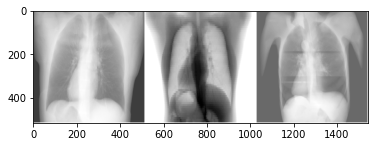

In [3]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
# get some random training images
dataiter = iter(dl_training)
sample = dataiter.next()
# create grid of images
img_grid = vutils.make_grid(sample[generator_target])
# show images
matplotlib_imshow(img_grid, one_channel=True)

msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1)
msssim_loss = 1 - msssim(sample["boneless"], sample["source"])
print(msssim_loss)

In [4]:
# Implementation of Network
def weights_init(m):
    # From DCGAN paper
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    """for i in m.children():
        # Specific weight setting for ResUNet shortcut.
        if i.__class__.__name__ == "ResUNet_shortcut":
            for ii in i.children():
                if isinstance(ii, nn.Conv2d) or isinstance(ii, nn.ConvTranspose2d):
                    nn.init.constant_(ii.weight.data, 1.)
            for param in i.parameters():
                param.requires_grad=False"""


# Network Structure
_initial_channels_out = 32 # Diakogiannis et al. ResUNet-A: A deep learning framework for semantic segmentation of remotely-sensed data
_input_array_shape_classifier = (_batch_size, 2 , image_spatial_size[0], image_spatial_size[1])  # 2 channels -- channel 0 for source, channel 1 for real/fake boneless
_input_array_shape_generator = (_batch_size, 1 , image_spatial_size[0], image_spatial_size[1])


netG = blocks.Generator_ResUNet_modified(_input_array_shape_generator, _first_out_channels=64,
                                _reluType="leaky", _dropoutType="ADL", _drop_rate=0.75)
"""
netG = blocks.Generator_Pix2Pix(_input_array_shape_generator, 
                                _normType="BatchNorm", _dropoutType = "ADL", _dropRate=0.5)

netG = blocks.Generator_ResUNet_A(_input_channels=_initial_channels_out, _input_array_shape=_input_array_shape_generator,
                                  _norm_type='BatchNorm', _ADL_drop_rate=0.75, _ADL_gamma=0.9)
"""
netD = blocks.MultiScale_Classifier(_input_channels=_initial_channels_out, _input_array_shape=_input_array_shape_classifier,
                                    _classifier_out_channels=64,
                                    _norm_type='BatchNorm', _ADL_drop_rate=0.75, _ADL_gamma=0.9)

# Initialise weights
netG.apply(weights_init)
netD.apply(weights_init)

# Multi-GPU
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

netG = netG.to(device)
netD = netD.to(device)

# Fixed Test Sample
dl_test = DataLoader(ds_generator, batch_size=_batch_size,
                        shuffle=False, num_workers=0)
fixed_test_image = next(iter(dl_test))

In [5]:
# Training loop for Generator first
import pytorch_msssim
if flag_retrain_intermediate_network or not(os.path.isfile(PATH_G_int1)):
    # Optimiser
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_pretraining, betas=(beta1_pretraining, beta2_pretraining))
    
    # Loss
    def criterion_Gusarev(testImage, referenceImage, alpha=0.84):
        mseloss = nn.MSELoss() # L2 used for easier optimisation
        
        msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1)
        msssim_loss = 1 - msssim(testImage, referenceImage)
        
        total_loss = (1-alpha)*mseloss(testImage, referenceImage) + alpha*msssim_loss
        return total_loss
    
    # Data Input
    img_list_pretraining = []
    iters=0
    print("Beginning Training...")
    for epoch in range(num_epochs_generator_pretraining):
        # For each batch in the dataloader
        for i, data in enumerate(dl_training):
            # Save a training image
            if iters == 0:
                fixed_training_image = data['source']
            ##############################
            # Match NetG output to the ground-truth
            ##############################
            netG.zero_grad()
            noisy_data = data['source'].to(device)
            fake = netG(noisy_data)
            loss = criterion_Gusarev(fake, data[generator_target].to(device))
            loss.backward() # calculate gradients
            optimizerG.step() # optimiser step along gradients
            
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_G: %.4f'
                      % (epoch, num_epochs_generator_pretraining, i, len(dl_training),
                         loss.item()))
            # Record generator output
            if (iters % 100 == 0) or ((epoch == num_epochs_generator_pretraining-1) and (i == len(dl_training)-1)):
                with torch.no_grad():
                    fake = netG(fixed_training_image).detach().cpu()
                img_list_pretraining.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1

    torch.save(netG.state_dict(), PATH_G_int1)
    
if not(flag_retrain_intermediate_network) and os.path.isfile(PATH_G_int1):
    # If not retraining, load the network into netG
    print("Loading Saved Pre-trained State")
    netG.load_state_dict(torch.load(PATH_G_int1))
    

Beginning Training...


C:\Users\Y1112\anaconda3\envs\daniel\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


[0/50][0/217]	Loss_G: 0.5167
[0/50][50/217]	Loss_G: 0.0526
[0/50][100/217]	Loss_G: 0.0473
[0/50][150/217]	Loss_G: 0.0496
[0/50][200/217]	Loss_G: 0.0502
[1/50][0/217]	Loss_G: 0.0420
[1/50][50/217]	Loss_G: 0.0670
[1/50][100/217]	Loss_G: 0.0514
[1/50][150/217]	Loss_G: 0.0501
[1/50][200/217]	Loss_G: 0.0483
[2/50][0/217]	Loss_G: 0.0666
[2/50][50/217]	Loss_G: 0.0587
[2/50][100/217]	Loss_G: 0.0395
[2/50][150/217]	Loss_G: 0.0539
[2/50][200/217]	Loss_G: 0.0477
[3/50][0/217]	Loss_G: 0.0436
[3/50][50/217]	Loss_G: 0.0584
[3/50][100/217]	Loss_G: 0.0409
[3/50][150/217]	Loss_G: 0.0512
[3/50][200/217]	Loss_G: 0.0564
[4/50][0/217]	Loss_G: 0.0439
[4/50][50/217]	Loss_G: 0.0305
[4/50][100/217]	Loss_G: 0.0398
[4/50][150/217]	Loss_G: 0.0484
[4/50][200/217]	Loss_G: 0.0461
[5/50][0/217]	Loss_G: 0.0549
[5/50][50/217]	Loss_G: 0.0431
[5/50][100/217]	Loss_G: 0.0471
[5/50][150/217]	Loss_G: 0.0426
[5/50][200/217]	Loss_G: 0.0400
[6/50][0/217]	Loss_G: 0.0586
[6/50][50/217]	Loss_G: 0.0416
[6/50][100/217]	Loss_G: 0.038

tensor(1.0000),tensor(0.)


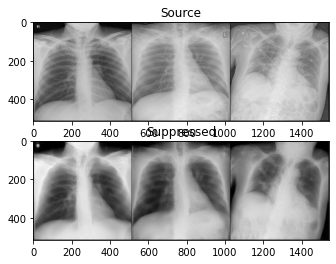

In [6]:
# INFERENCE OUTPUTS

# Fixed Test Sample
fixed_test_image = next(iter(dl_testing))
fixed_training_image = next(iter(dl_training))

with torch.no_grad():
    input_image = fixed_test_image['source'] #fixed_test_image['source']
    input_images = vutils.make_grid(input_image, padding=2, normalize=True)
    output_image = netG(input_image).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)

print(str(torch.max(input_images)) + "," + str(torch.min(input_images)))

fig, ax = plt.subplots(2,1)
ax[0].imshow(np.transpose(input_images, (1,2,0)))
ax[0].set_title("Source")
ax[1].imshow(np.transpose(output_images, (1,2,0)))
ax[1].set_title("Suppressed")
plt.show
fig.savefig(os.path.join(output_save_directory, current_date + "pretraining"+".png"))

In [7]:
## Training Loop for GAN

# Loss Function
def criterion_Pix2Pix(input_image, ground_truth_image, input_label, ground_truth_label, reg_lambda=100):
    L_cGAN = nn.BCELoss(reduction="mean")
    L_l1 = nn.L1Loss(reduction="mean")
    return L_cGAN(input_label , ground_truth_label) + reg_lambda*L_l1(input_image , ground_truth_image)
def criterion_BCE(input_label, ground_truth_label):
    L_cGAN = nn.BCELoss(reduction="mean")
    return L_cGAN(input_label, ground_truth_label)

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_G_z1_list = []
D_G_z2_list = []
D_x_list = []
iters = 0

print("Beginning Training...")
# For each epoch
for epoch in range(num_epochs_generator):
    # For each batch in the dataloader
    for i, data in enumerate(dl_training):
        ############################
        # Labels
        ############################
        # Label Smoothing as mentioned by Salimans et al. 2016 Improved Techniques for Training GANs
        real_label = random.uniform(0.7,1.2) 
        fake_label = random.uniform(0.0,0.3)
        
        # Label flipping to cripple discriminator
        flip_probability = random.uniform(0.,1.)
        fake_label_original = fake_label
        real_label_original = real_label
        if flip_probability < flip_rate_threshold:
            fake_label = real_label_original
            real_label = fake_label_original
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        # Generate fake image batch with G
        netG.zero_grad()
        conditioning_data = data['source'].to(device)
        fake = netG(conditioning_data)    
        fake = fake.cpu()
        
        ## Train with all-real batch
        netD.zero_grad()
        # Condition the data
        b_data = torch.cat((data['source'], data[generator_target]), dim=1)
        real_cpu = b_data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        #errD_real = 0.5*criterion_Pix2Pix(data[generator_target].detach(), data[generator_target].detach(), output, label)
        errD_real = 0.5*criterion_BCE(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        label.fill_(fake_label)
        b_data = torch.cat((data['source'] , fake.detach()), dim=1)
        fake_cpu = b_data.to(device)
        # Classify all fake batch with D
        # Fake is detached because the .backwards() command destroys parts of the computational graph
        output = netD(fake_cpu).view(-1)
        # Calculate D's loss on the all-fake batch
        #errD_fake = 0.5*criterion_Pix2Pix(fake.detach(), data[generator_target].detach(), output, label)
        errD_fake = 0.5*criterion_BCE(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        real_label = real_label_original # only flip for discriminator
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # fake CANNOT be detached here.
        b_data = torch.cat((data['source'] , fake), dim=1)
        fake_cpu = b_data.to(device)
        output = netD(fake_cpu).view(-1)
        # Calculate G's loss based on this output
        errG = criterion_Pix2Pix(fake.detach(), data[generator_target].detach(), output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x,z): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs_generator, i, len(dl_training),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_G_z1_list.append(D_G_z1)
        D_G_z2_list.append(D_G_z2)
        D_x_list.append(D_x)
        
        # Check how the generator is doing by saving G's output on a fixed test image
        if (iters % 100 == 0) or ((epoch == num_epochs_generator-1) and (i == len(dl_training)-1)):
            with torch.no_grad():
                fake = netG(fixed_test_image['source']).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        if flag_debug and i == 2:
            print(iters)
            print("DEBUGGING -- REMOVE THIS IF CONDITION IN FULL TEST")
            break
    if flag_debug and epoch == 2:
        print("DEBUGGING -- REMOVE THIS IF CONDITION IN FULL TEST")
        break



Beginning Training...


C:\Users\Y1112\anaconda3\envs\daniel\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


[0/10][0/217]	Loss_D: 0.6651	Loss_G: 2.7058	D(x,z): 0.4318	D(G(z)): 0.4309 / 0.2785
[0/10][50/217]	Loss_D: 0.7291	Loss_G: 7.1423	D(x,z): 0.6491	D(G(z)): 0.6471 / 0.5156
[0/10][100/217]	Loss_D: 0.7219	Loss_G: 4.5287	D(x,z): 0.4087	D(G(z)): 0.4043 / 0.4774
[0/10][150/217]	Loss_D: 0.6600	Loss_G: 3.7725	D(x,z): 0.5441	D(G(z)): 0.5391 / 0.6611
[0/10][200/217]	Loss_D: 0.6859	Loss_G: 6.3639	D(x,z): 0.5210	D(G(z)): 0.5194 / 0.4895
[1/10][0/217]	Loss_D: 0.6825	Loss_G: 5.5659	D(x,z): 0.5160	D(G(z)): 0.5069 / 0.5140
[1/10][50/217]	Loss_D: 0.8464	Loss_G: 5.9551	D(x,z): 0.7061	D(G(z)): 0.7083 / 0.5733
[1/10][100/217]	Loss_D: 0.6987	Loss_G: 5.1406	D(x,z): 0.5316	D(G(z)): 0.5307 / 0.5061
[1/10][150/217]	Loss_D: 0.6263	Loss_G: 3.9708	D(x,z): 0.6529	D(G(z)): 0.6534 / 0.7012
[1/10][200/217]	Loss_D: 0.6566	Loss_G: 6.7212	D(x,z): 0.6122	D(G(z)): 0.6105 / 0.6461
[2/10][0/217]	Loss_D: 0.7034	Loss_G: 4.2701	D(x,z): 0.4913	D(G(z)): 0.4963 / 0.5832
[2/10][50/217]	Loss_D: 0.6617	Loss_G: 2.7035	D(x,z): 0.5700	D(

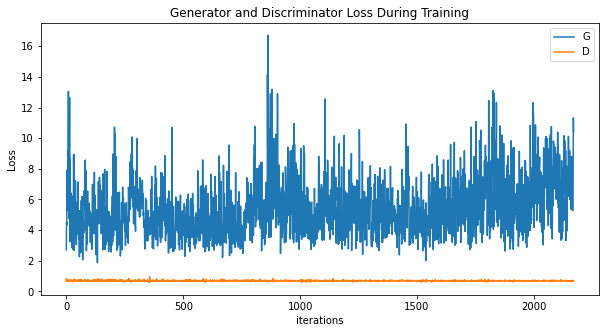

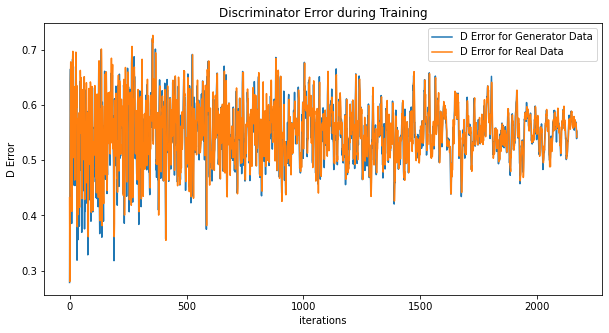

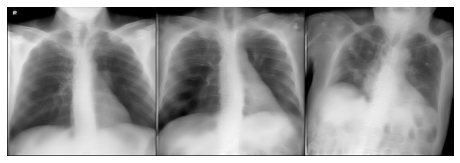

In [8]:
# SAVE WEIGHTS
torch.save(netG.state_dict(), PATH_G)
torch.save(netD.state_dict(), PATH_D)

# Plot G and D loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(output_save_directory, current_date + "training_loss"+".png"))
plt.show()
# Plot D errors
plt.figure(figsize=(10,5))
plt.title("Discriminator Error during Training")
plt.plot(D_G_z2_list,label="D Error for Generator Data")
plt.plot(D_x_list,label="D Error for Real Data")
plt.xlabel("iterations")
plt.ylabel("D Error")
plt.legend()
plt.savefig(os.path.join(output_save_directory, current_date + "D_errors"+".png"))
plt.show()

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]


ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
ani.save(os.path.join(output_save_directory, current_date+"generator_output.mp4"), dpi=300)

In [9]:


"""# TENSORBOARD Visualisation
writer = tensorboard.SummaryWriter(Path('runs/MSAGAN_v1'))

# get some random training images
dataiter = iter(dl_training)
sample = dataiter.next()
print(sample['source'].shape)
# create grid of images
img_grid = vutils.make_grid(sample['source'])

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('Images', img_grid)

writer.add_graph(netG, sample['source'])
writer.close()

%load_ext tensorboard
%tensorboard --logdir runs"""

"# TENSORBOARD Visualisation\nwriter = tensorboard.SummaryWriter(Path('runs/MSAGAN_v1'))\n\n# get some random training images\ndataiter = iter(dl_training)\nsample = dataiter.next()\nprint(sample['source'].shape)\n# create grid of images\nimg_grid = vutils.make_grid(sample['source'])\n\n# show images\nmatplotlib_imshow(img_grid, one_channel=True)\n\n# write to tensorboard\nwriter.add_image('Images', img_grid)\n\nwriter.add_graph(netG, sample['source'])\nwriter.close()\n\n%load_ext tensorboard\n%tensorboard --logdir runs"

In [10]:
not(os.path.isfile(PATH_G_int1))

False